0.04182789877442439
0.00792335903589438
0.0021170626207614673


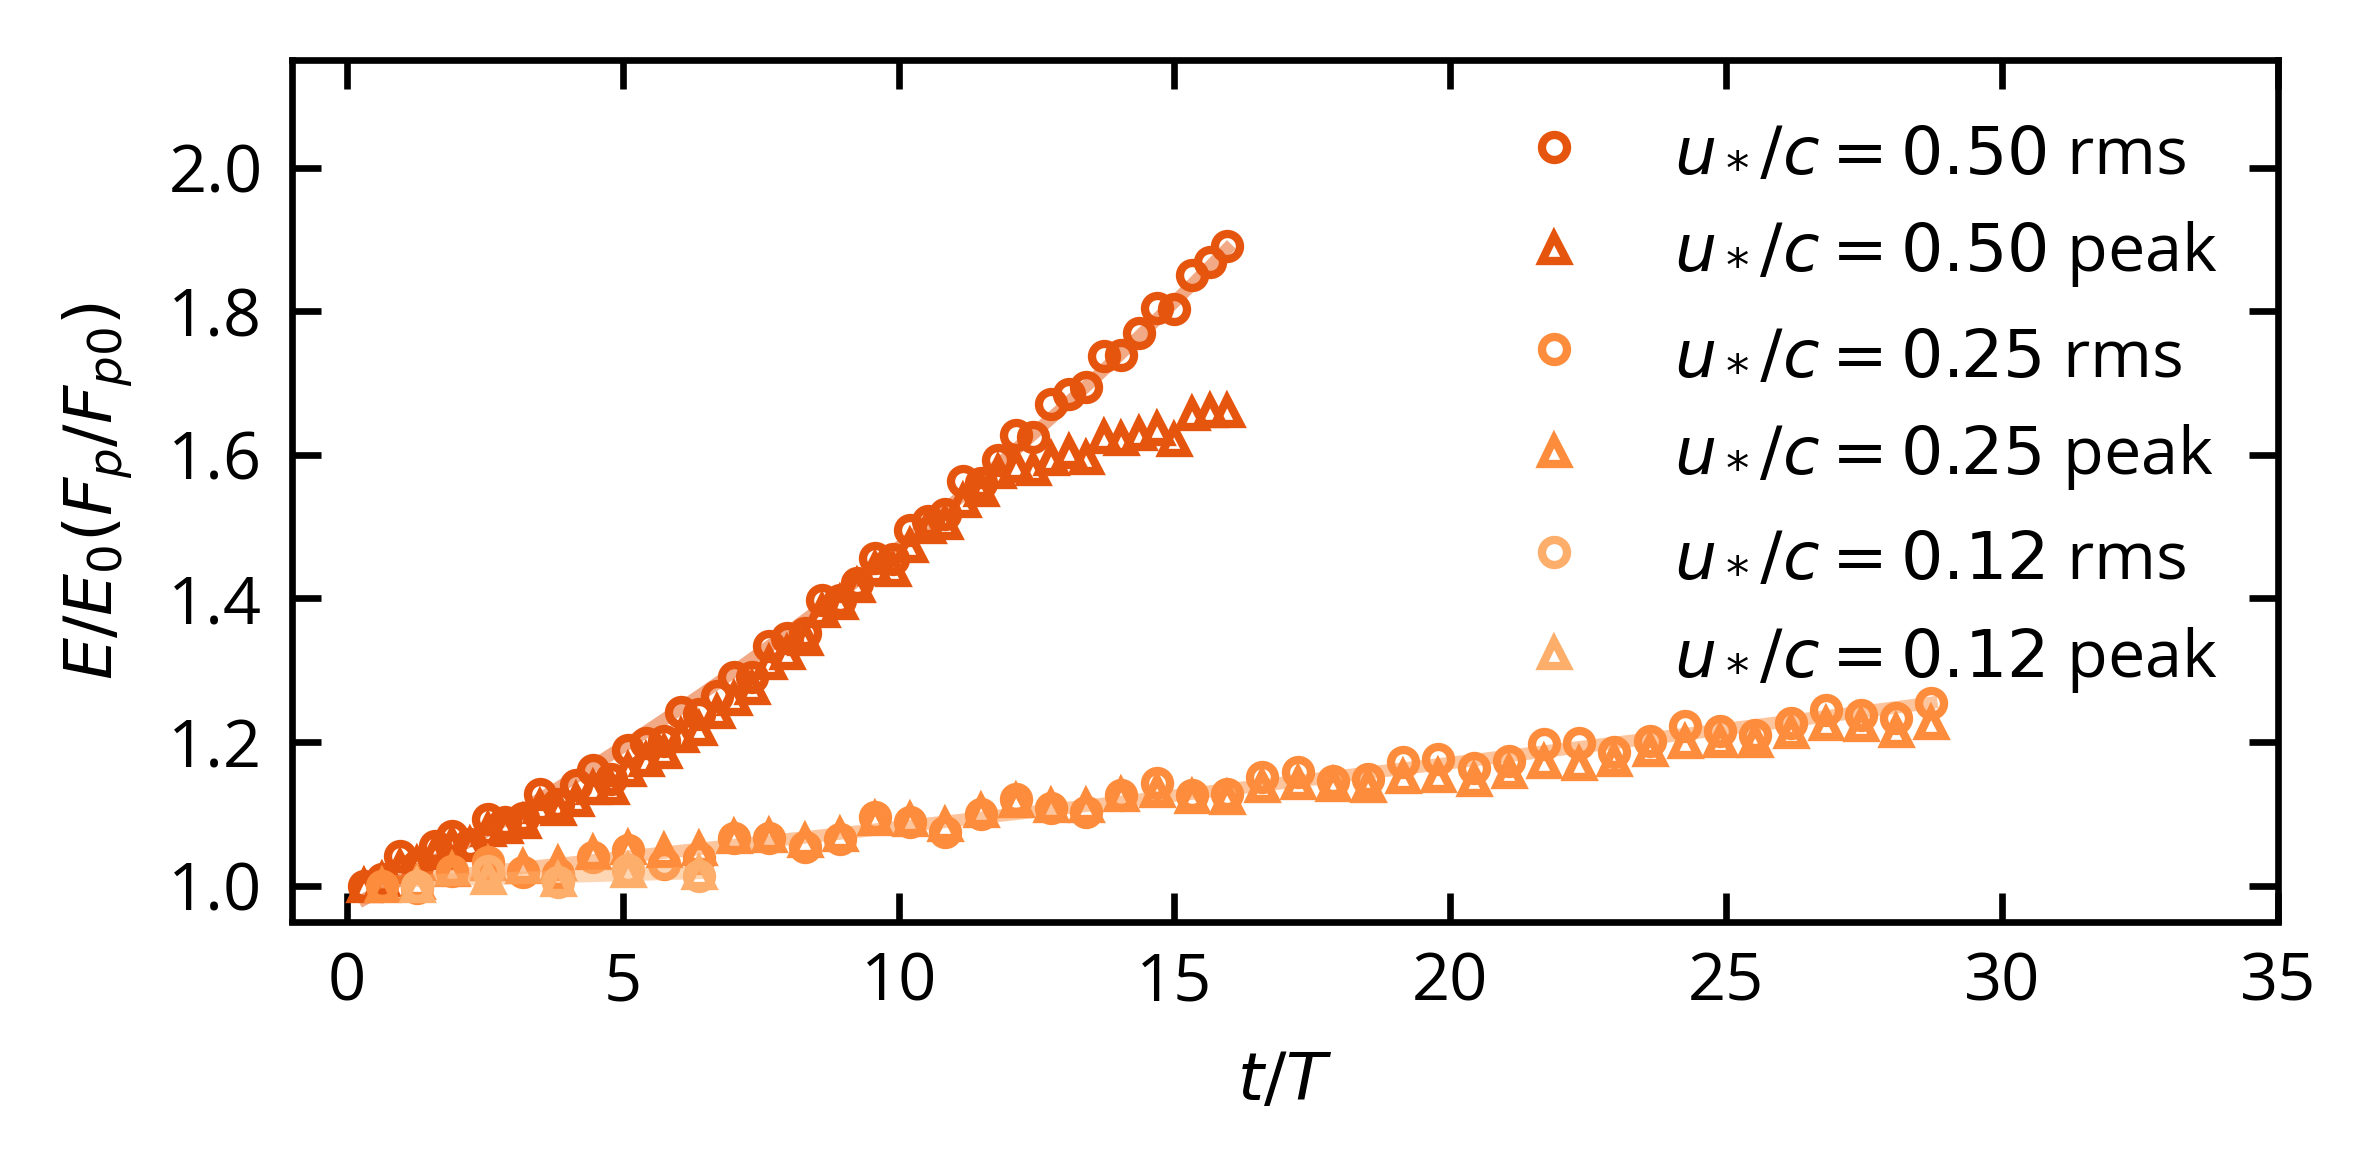

In [17]:
"""Wave growth plot"""

fig = plt.figure(figsize=[4,2]); ax = plt.gca()

"""Plot the rms eta or the Fp"""
def plotE(case, markercolor=plt.get_cmap('tab20c')(4)):
    T = 2*np.pi/case.wave.omega     
    plt.plot(case.t/T, case.Erms/case.Erms[0], marker = 'o', mfc='none',
             label=r'$u_*/c=%.2f$ rms' %(case.ustar/case.wave.c), lw=0, markersize=3, color=markercolor, alpha = 1) 
    plt.plot(case.t/T, case.Ep/case.Ep[0], color=markercolor, marker = '^', mfc='none',
             markeredgewidth=1, lw=0, markersize=3, label=r'$u_*/c=%.2f$ peak' %(case.ustar/case.wave.c))

"""Fit an exponential"""
def fit_exponential(case, linecolor=plt.get_cmap('tab20c')(4)):
    T = 2*np.pi/case.wave.omega
    case.wa, wb = np.polyfit(case.t/T, np.log(case.Erms/case.Erms[0]), 1)
    plt.plot(case.t/T, np.exp(case.wa*case.t/T+wb), color=linecolor, alpha = 0.5)
    print(case.wa)

colorscheme = (plt.get_cmap('tab20c')(4),plt.get_cmap('tab20c')(5), plt.get_cmap('tab20c')(6))
for (case, color) in zip((case1,case2,case3), colorscheme):
    plotE(case, color)
    fit_exponential(case, color)


# ax.text(0.4, 0.9, r'$\bar{\beta} = %.3f$' % case1.wa, ha='center', va='center', rotation=0., fontsize=6, 
#         color=plt.get_cmap('tab20c')(4), transform=ax.transAxes)
# ax.text(0.87, 0.48, r'$\bar{\beta} = %.3f$' % case2.wa, ha='center', va='center', rotation=0., fontsize=6, 
#         color=plt.get_cmap('tab20c')(5), transform=ax.transAxes)
plt.xlabel(r'$t/T$'); plt.ylabel(r'$E/E_0 (F_p/F_{p0})$'); plt.ylim([0.95,2.15]); plt.xlim([-1,35])
plt.legend(loc='upper right')

In [72]:
12*(2*np.pi/case1.wave.omega)+57

94.60521602643566

In [59]:
"""Write a moving window thing to compute the pressure forcing term and the growth rate (dE/dt directly not the exponential)"""

case = case2
tau0 = case.rho2*case.ustar**2
mu_a = case.mu2; rho_a = case.rho2
nu_a = mu_a/rho_a

for j in range(0, np.size(case.t)):
    case.interface[j].stress(tau0,mu_a)

# List comprehension
formdrag_all = [interface.formdrag for interface in case.interface]
    
case.isample = []
# Ensemble average of different time
p1d_t = []; tau1d_t = []; formdrag_t = []
for j in tqdm(range (2,44,2)):
    p1d_winaver = []; tau1d_winaver = []; formdrag_winaver = []
    case.isample.append(j)
    # Average over 5 time around the center t
    for i in range(j-2,j+3):
        interface = case.interface[i]
        p1d = np.average(interface.p/tau0, axis=0)
        p1d_shift = np.roll(p1d, -(interface.idx), axis=0)
        p1d_winaver.append(p1d_shift)
        tau1d = np.average(interface.tau_nux/tau0, axis=0)
        tau1d_shift = np.roll(tau1d, -(interface.idx), axis=0)
        tau1d_winaver.append(tau1d_shift)
        formdrag_winaver.append(interface.formdrag)
        
    p1d_t.append(np.average(p1d_winaver, axis=0))
    tau1d_t.append(np.average(tau1d_winaver, axis=0))
    formdrag_t.append(np.average(formdrag_winaver, axis=0))

case.isample = np.array(case.isample)

100%|██████████| 21/21 [00:00<00:00, 266.68it/s]


Text(0.5, 1.0, '$u_*/c=0.25$')

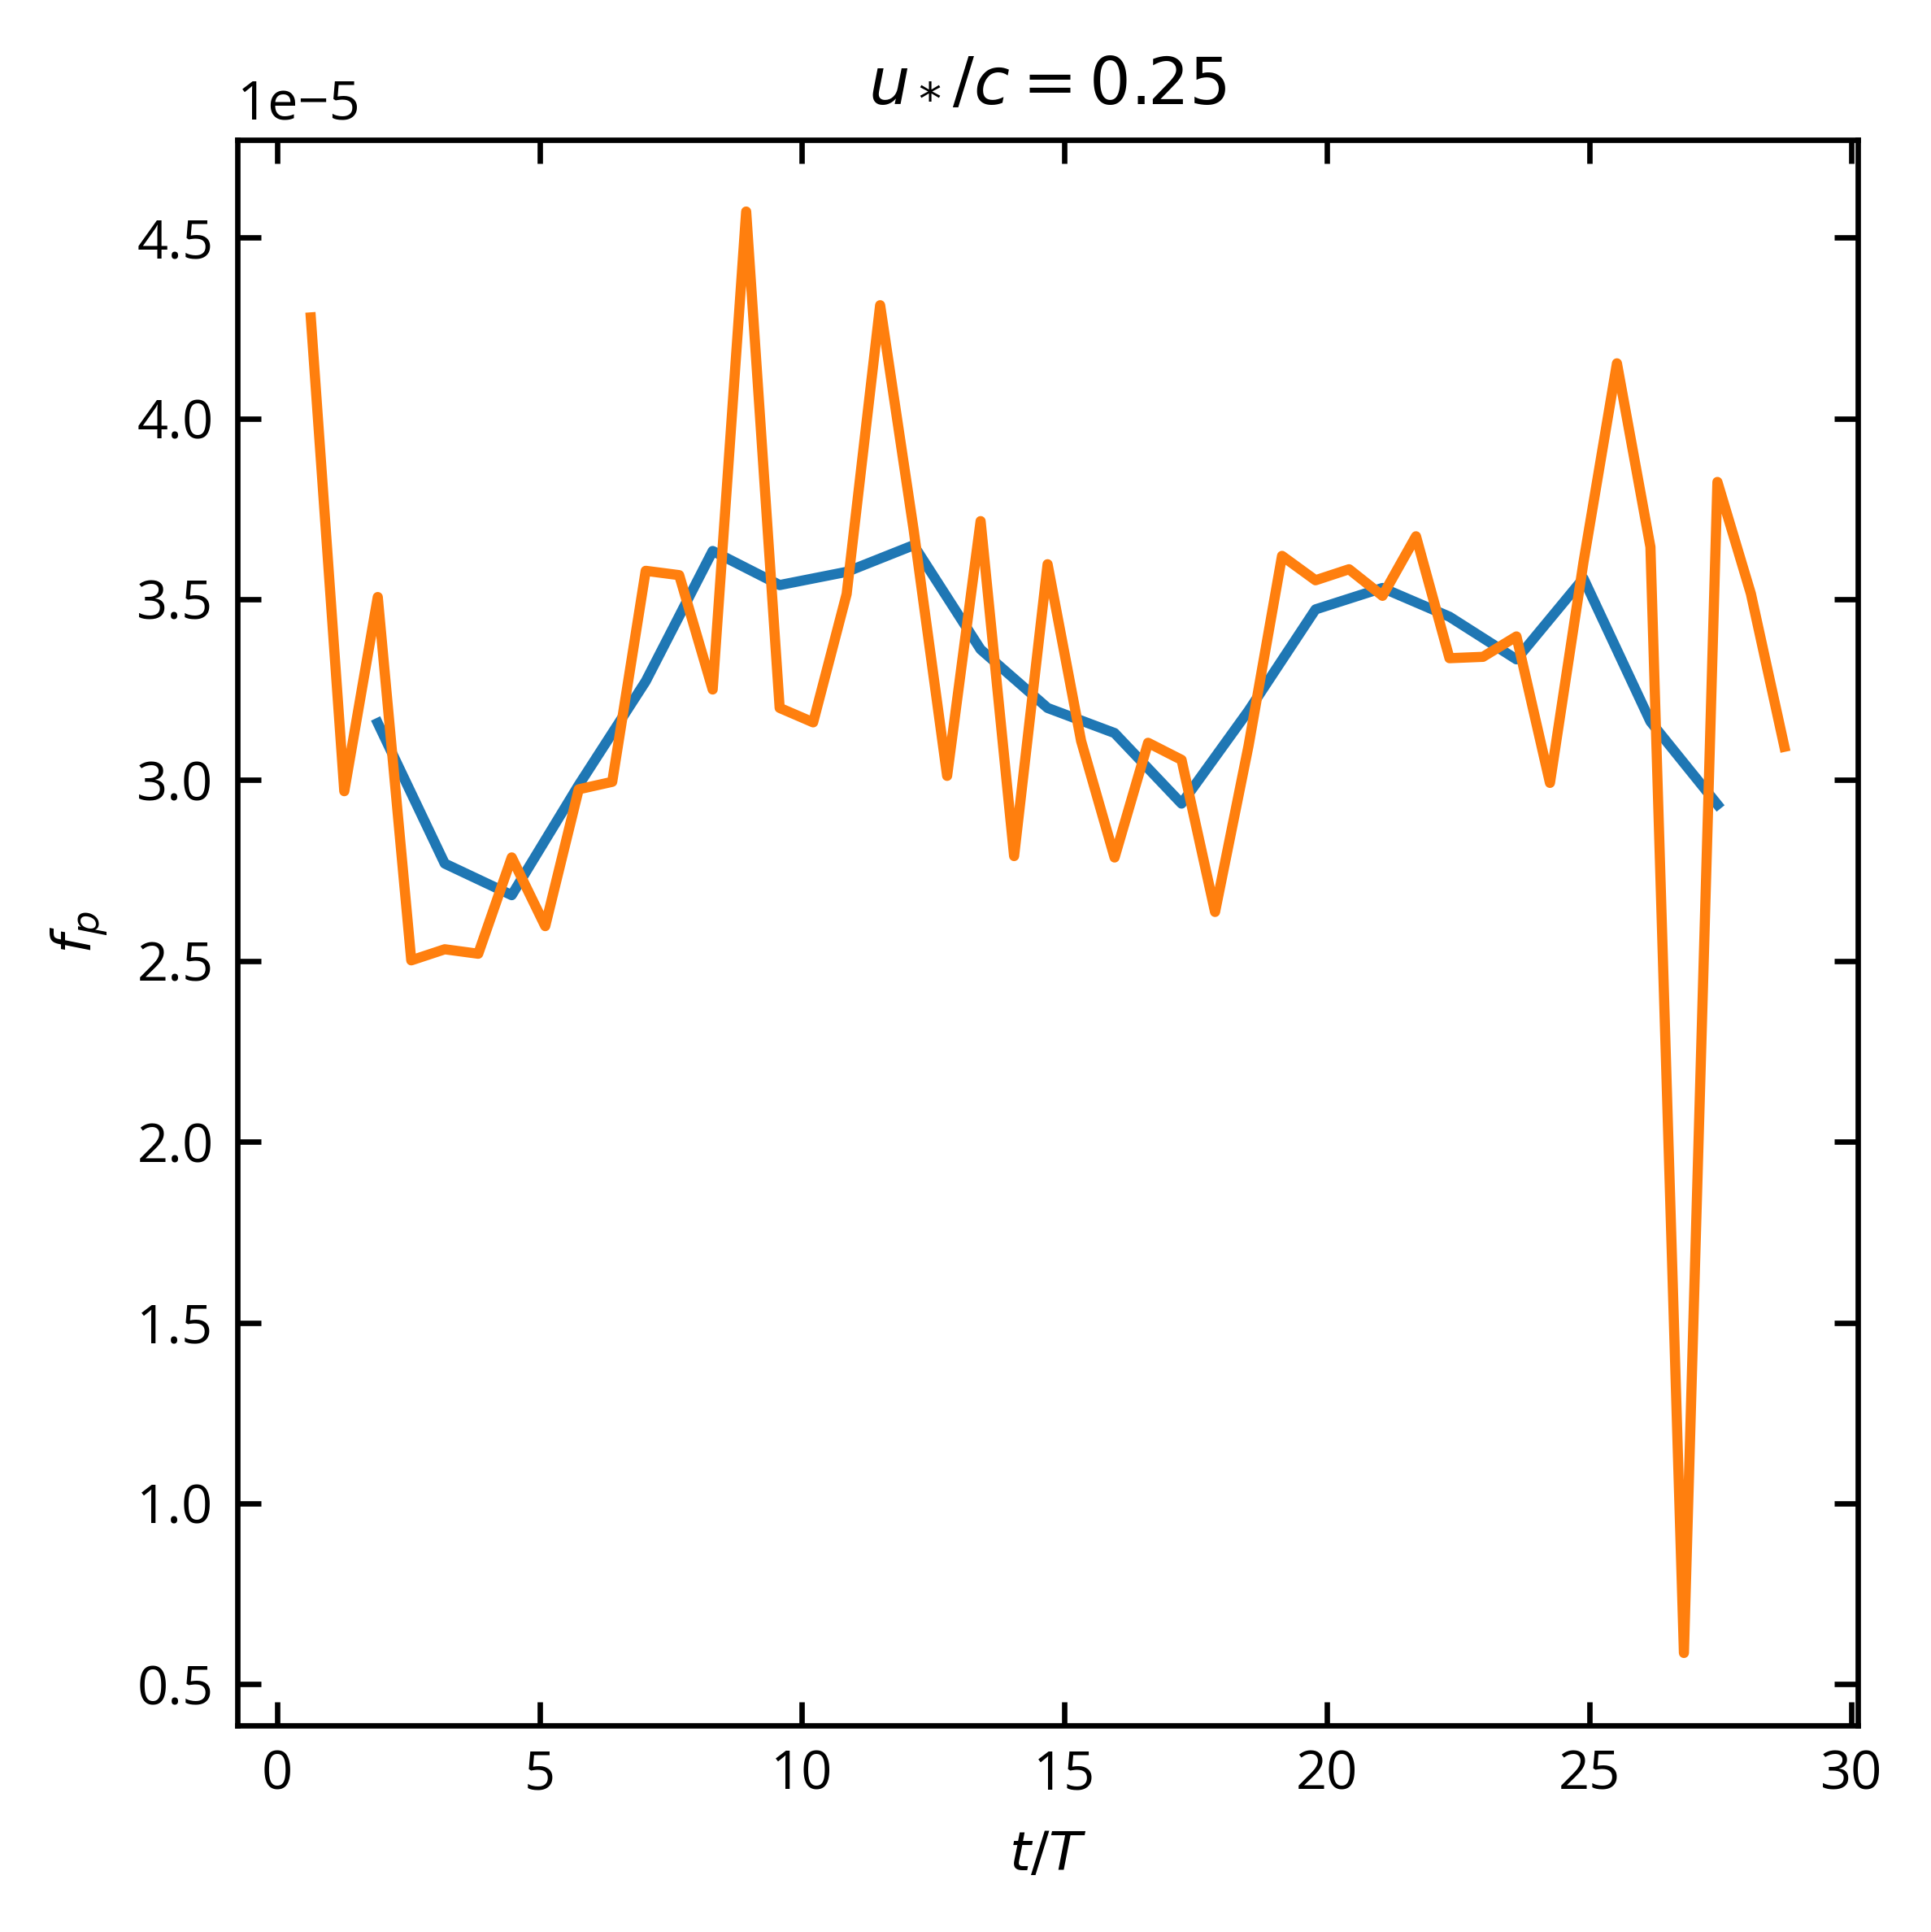

In [60]:
plt.plot()
plt.plot(case.t[case.isample]*case.wave.omega/2/np.pi, formdrag_t)
plt.plot(case.t*case.wave.omega/2/np.pi, formdrag_all)
plt.ylabel(r'$f_p$')
plt.xlabel(r'$t/T$')
plt.title(r"$u_*/c=%.2f$" %(case.ustar/case.wave.c))

Text(0.5, 1.0, '$t=1.9-26.2T, u_*/c=0.25$')

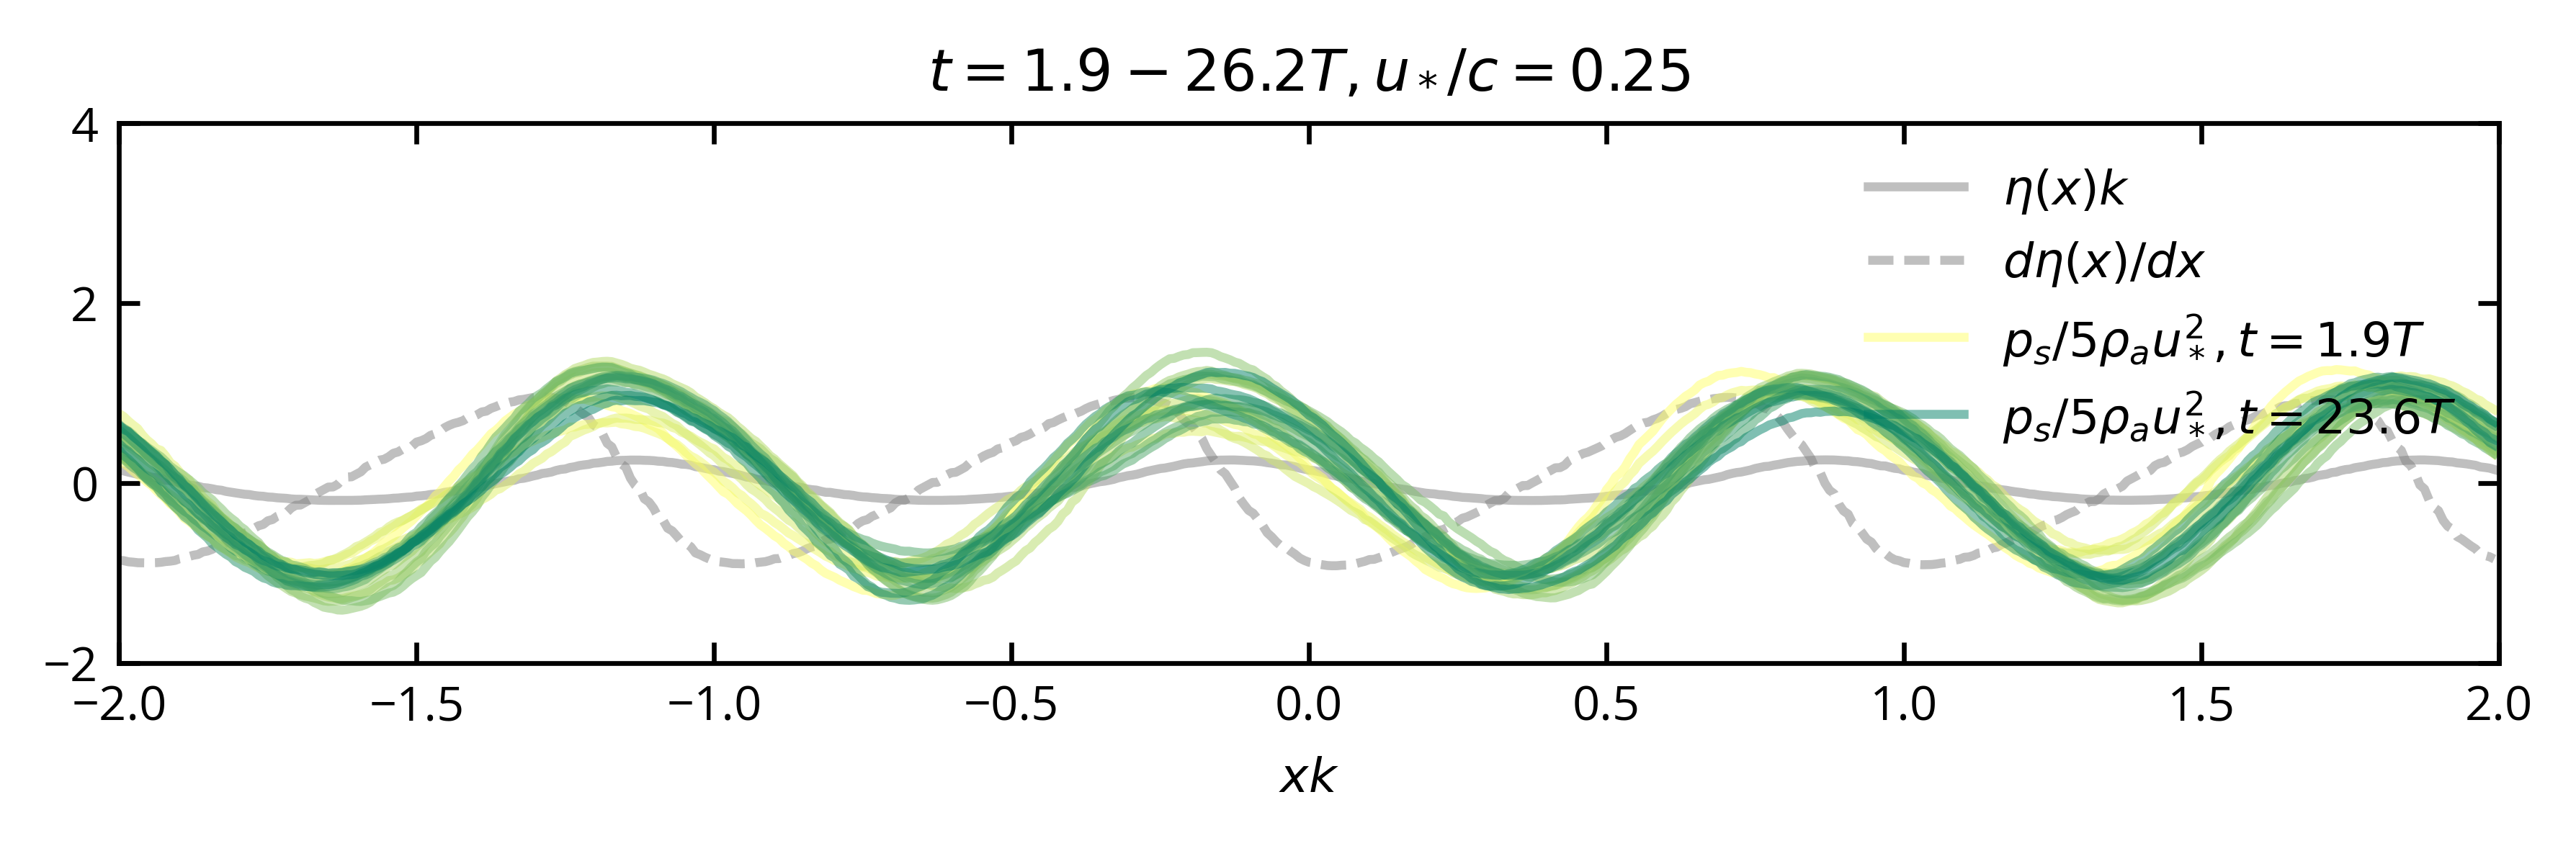

In [69]:
fig = plt.figure(figsize=[6,2])
L0 = 2*np.pi; N =512
eta_1D_filtered = np.roll(np.average(interface.eta, axis=0), -(interface.idx), axis=0)
deta_dx = np.roll(np.average(interface.grad, axis=0), -(interface.idx), axis=0)
r1 = 0
r2 = 512

plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), (eta_1D_filtered-1)[r1:r2]*4, alpha=0.5, label=r'$\eta(x)k $', color='gray')
plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), deta_dx[r1:r2]*4, '--', alpha=0.5, label=r'$d\eta(x)/dx $', color='gray')
for (i,p1d) in enumerate(p1d_t[0:-3]):
    if i == 0 or i == 17:
        plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), p1d[r1:r2]/5, label=r'$p_s/5\rho_{a}u_*^2, t = %.1fT$' %(case.t[case.isample[i]]*case.wave.omega/(2*np.pi)), 
                 color=plt.cm.get_cmap('summer')(1-i/17), alpha = 0.5)
    else:
        plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), p1d[r1:r2]/5,
                 color=plt.cm.get_cmap('summer')(1-i/17), alpha = 0.5) 
# for (i,tau1d) in enumerate(tau1d_phase_aver):
#     plt.plot(interface.xarray[r1:r2]/(2*np.pi/4), tau1d[r1:r2], label=r'$\tau_{\nu x}/\rho_{a}u_*^2$', color=plt.cm.get_cmap('summer')(1-i/5))

"""Find the phase difference"""
# from scipy.signal import argrelextrema
# maxm1 = argrelextrema(p1d_phase_aver[r1:r2], np.greater)  # (array([1, 3, 6]),)
# maxm2 = argrelextrema(eta_1D_filtered[r1:r2], np.greater)  # (array([1, 3, 6]),)
# x1 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][5]])/(2*np.pi/4)
# x2 = np.ones(20)*(interface.xarray[r1:r2][maxm1[0][7]])/(2*np.pi/4)
# x1 = np.ones(20)*(-1.2)
# y1= np.linspace(1.4,2.1,20)
# plt.plot(x1,y1,'--', color='k',lw=1)
# x2 = np.ones(20)*(-1)
# y2= np.linspace(0.5,2.1,20)
# plt.plot(x2,y2,'--', color='k',lw=1)
# plt.text(-1.15, 1.8, r'$\Delta\phi$')

plt.ylim([-2,4])
plt.xlim([-2,2])
# plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.legend(loc = 'upper right')
plt.xlabel(r'$xk$')
plt.title(r"$t=%.1f-%.1fT, u_*/c=%.2f$" %(case.t[case.isample[0]]/(2*np.pi/case.wave.omega), case.t[case.isample[-2]]/(2*np.pi/case.wave.omega), (case.ustar/case.wave.c)))

In [ ]:
"""Concurrent dissipation and wind input."""

In [167]:
"""Compute the time series of peak frequency energy."""
case = case2
case.Ep = []; case.Erms = []
case.interface = [] # Sampling interface (full information)
for t in tqdm(case.t):
    interface = Interface2D(L0 = case.L0, N = case.N, 
                            path = case.path, pre='eta/eta_loc_t', t = t, PRUNING=True)
    interface.spectrum(peak = 4)
    case.interface.append(interface)
    case.Ep.append(interface.Ep)
    case.Erms.append(np.std(interface.eta)**2)

 10%|█         | 2/20 [00:16<02:25,  8.06s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 15%|█▌        | 3/20 [00:24<02:17,  8.10s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 25%|██▌       | 5/20 [00:40<02:01,  8.13s/it]/home/jiarong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
 30%|███       | 6/20 [00:49<01:55,  8.23s/it]/home/jiarong/anaconda3/lib/pytho

In [185]:
case = case1
case.Ep = np.array(case.Ep); case.Erms = np.array(case.Erms)
case.t = np.array(case.t-case.tstart)

In [184]:
case1.tstart = 57